In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# necessary libraries 
import numpy as np 
import pandas as pd
import keras.backend as K
from keras.layers import Dense, Dropout, Embedding, Input, Reshape, Concatenate
from keras.models import Model

In [ ]:
#zip file reading section 
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/demand-forecasting-kernels-only.zip", 'r')
zip_ref.extractall("/demandforecasting")
zip_ref.close()

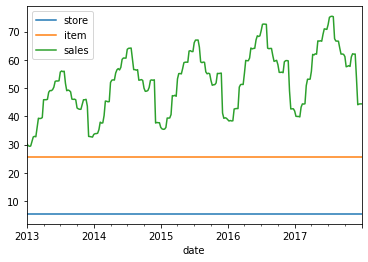

In [ ]:
# train = pd.read_csv("/demandforecasting/train.csv", parse_dates= True, index_col = 0)
# test = pd.read_csv("/demandforecasting/test.csv", parse_dates=True,index_col =1 )

# sample = pd.read_csv("/demandforecasting/sample_submission.csv")


train_data = pd.read_csv("/demandforecasting/train.csv", parse_dates=True, index_col =0)
#plot and try to understand the trend of the graph 
train_data.groupby('date').mean().resample("w").mean().plot()
#selecting the last column to be predicted 
y_train = train_data.iloc[:,-1].values
#dropping the last column which is 'sales'
train_data.drop('sales', 1, inplace=True)
#separating the index column from the 'date' column 
train_data['y'] = train_data.index.year-train_data.index.year.min()
train_data['m'] = train_data.index.month
train_data['d'] = train_data.index.day
train_data['dow'] = train_data.index.dayofweek

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_data, y_train, test_size=.1, random_state=0, shuffle = True)

In [ ]:
#  this is just for checking 
cat_var = list(train_data.columns)
cat_var 
train_data
# upto this portion nice! 

,store,item,y,m,d,dow
date,,,,,,
2013-01-01,1,1,0,1,1,1
2013-01-02,1,1,0,1,2,2
2013-01-03,1,1,0,1,3,3
2013-01-04,1,1,0,1,4,4
2013-01-05,1,1,0,1,5,5
...,...,...,...,...,...,...
2017-12-27,10,50,4,12,27,2
2017-12-28,10,50,4,12,28,3
2017-12-29,10,50,4,12,29,4


In [ ]:
cat_vars = list(train_data.columns)
cat_vars.remove('y')
# Only year is not categorical, as the value of years are numerically comparable.
cont_vars = ['y']

In [ ]:

X_train = []
X_val = []
X_train.append(x_train[cont_vars].astype('float32').values)
X_val.append(x_val[cont_vars].astype('float32').values)

for cat in cat_vars:
    X_train.append(x_train[cat].values)
    X_val.append(x_val[cat].values)

# https://kanoki.org/2019/10/09/working-with-pandas-datetime/

In [ ]:
cat_sizes = {}
cat_embsizes = {}
for cat in cat_vars:
    cat_sizes[cat] = train_data[cat].nunique()
    cat_embsizes[cat] = min(50, cat_sizes[cat]//2+1)

In [ ]:
cat_embsizes


{'d': 16, 'dow': 4, 'item': 26, 'm': 7, 'store': 6}

In [ ]:
test_data = pd.read_csv("/demandforecasting/test.csv", parse_dates=True, index_col =1)
test_data['y'] = test_data.index.year-train_data.index.year.min()
test_data['m'] = test_data.index.month
test_data['d'] = test_data.index.day
test_data['dow'] = test_data.index.dayofweek

In [ ]:
X_test = []
X_test.append(test_data[cont_vars].astype('float32').values)
for cat in cat_vars:
    X_test.append(test_data[cat].values)

In [ ]:
import keras.backend as K

def custom_smape(x, x_):
    return K.mean(2*K.abs(x-x_)/(K.abs(x)+K.abs(x_)))

In [ ]:
y = Input((len(cont_vars),), name='cont_vars')
ins = [y]
concat = [y]
for cat in cat_vars:
    x = Input((1,), name=cat)
    ins.append(x)
    x = Embedding(cat_sizes[cat]+1, cat_embsizes[cat], input_length=1)(x)
    x = Reshape((cat_embsizes[cat],))(x)
    concat.append(x)
y = Concatenate()(concat)
y = Dense(100, activation= 'relu')(y)
# y = Dense(100, activation= 'relu')(y)
y = Dense(1)(y)
model = Model(ins, y)
model.summary()
model.compile('adadelta', custom_smape)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
store (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
m (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
d (InputLayer)                  [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
# X_train = X_train.astype('float32')
y_train= y_train.astype('float32')

# X_val = X_val.astype('float32')
y_val= y_val.astype('float32')
model.fit(X_train, y_train, 64, 2, validation_data=(X_val, y_val))
# a shitty explanation for the input and output tensor mismatch problem 
#validation_data: ... validation_data could be: - tuple (x_val, y_val) of Numpy arrays or tensors - tuple (x_val, y_val, val_sample_weights) of Numpy arrays - dataset ...
#So, validation_data has to be a tuple rather than a list (of Numpy arrays or tensors). We should use parentheses (round brackets) (...), not square brackets [...].

Epoch 1/2
12840/12840 [==============================] - 22s 2ms/step - loss: 1.9613 - val_loss: 1.8126
Epoch 2/2
12840/12840 [==============================] - 21s 2ms/step - loss: 1.7397 - val_loss: 1.4770


In [ ]:
test_preds = model.predict(X_test)
sample_data = pd.read_csv("/demandforecasting/sample_submission.csv", index_col=0)
sample_data['sales'] = test_preds
sample_data.to_csv('preds.csv')

In [ ]:
#resource links

# https://www.kaggle.com/rezas26/simple-keras-starter
#https://www.kaggle.com/danofer/getting-started-with-time-series-features

In [ ]:
result = pd.read_csv('preds.csv')
result 

,id,sales
0,0,12.976759
1,1,12.972337
2,2,12.959005
3,3,12.973466
4,4,12.959934
...,...,...
44995,44995,12.951926
44996,44996,12.973481
44997,44997,12.943542
44998,44998,13.000288
